# Pro tip: if you run the import once you get a lot of warning, but then you just run it again then the warning is gone

In [2]:
import impnb
import herMLE
import Data_processing as dp;
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Import_EEG as IE;
from scipy import stats

img_path='/cndd/hop006/Processing/PRL_imgs'
behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
plt_path='/cndd/hop006/Github/RewardReversalPorject/Plots/'
ERP_plot_path='/cndd/hop006/Github/RewardReversalPorject/Plots/ERP/'

# Part Zero: Gathering Data - every rat takes about 20s to process
#### Note: Only doing from rat_26 and up, some are not 20 days apart
#### Common electrodes: 
 Ag Disk (frontal center)',
 'L Au1 EEG',
 'L Cerebellum EEG',
 'L NAc LFP',
 'L lOFC LFP',
 'R ACC LFP',
 'R Au1 LFP',
 'R Caudate LFP',
 'R lOFC EEG'}

In [3]:
rat_2_anal=sorted(list(set(dp.day1['subject'])))[1:] # droped 25 cuz it only had one recording
del rat_2_anal[6] # also dropping the seventh one cuz there's a bug where there's one less reward
days=2
behavior_log={}

In [4]:
for myrat in rat_2_anal:
    val_chan,chan_name,dates,rat_nums,reward_tone=IE.get_excel_info(myrat)
    rat_rlogs=[]
    rat_alogs=[]
    for day in range(days):
        rat_df=IE.get_ephys(dates[day],rat_nums[day])
#          tvec,signal,low_tone,high_tone,tar,off_tar=IE.rat_summary(rat_df)
        action_log,reward_log,epoched_eeg=IE.get_behavior(rat_df,eeg_length=300,plot=False)
        rat_rlogs.append(reward_log)
        rat_alogs.append(action_log)
    behavior_log[myrat]={}
    behavior_log[myrat]['reward']=rat_rlogs
    behavior_log[myrat]['action']=rat_alogs

KeyboardInterrupt: 

In [5]:
behavior_df=pd.read_pickle(behavior_log_path+'rat26to38.pkl')

In [67]:
behavior_df=pd.DataFrame(behavior_log)
behavior_df.to_pickle(behavior_log_path+'rat26to38.pkl')

# Part One: Behavior Models
### Model-1: Q-learning with alpha_gain and loss, beta, and sigmoid action decision

In [86]:
alphaGs,alphaLs,betas={},{},{}
for myrat in rat_2_anal:
    alphaGs[myrat]={}
    alphaLs[myrat]={}
    betas[myrat]={}
    tempG=[]
    tempL=[]
    tempB=[]
    logs=behavior_df[myrat]
    rat_alogs=logs.loc['action']
    rat_rlogs=logs.loc['reward']
    for rlog,alog in zip(rat_rlogs,rat_alogs): #
        alphaG,alphaL,beta=herMLE.my_minimize(alog,rlog)
        print(alphaG,alphaL,beta)
        tempG.append(alphaG)
        tempL.append(alphaL)
        tempB.append(beta)
    alphaLs[myrat]['alphaL']=tempG
    alphaGs[myrat]['alphaG']=tempL
    betas[myrat]['beta']=tempB
    

0.0 0.05 11.5
0.05 0.65 3.0
0.0 0.05 0.5
0.9500000000000001 0.9500000000000001 1.0
0.0 0.05 2.0
0.25 0.9500000000000001 1.0
0.0 0.05 11.0
0.25 0.9500000000000001 1.0
0.0 0.05 14.0
0.9500000000000001 0.9500000000000001 1.0
0.0 0.05 12.5
0.15000000000000002 0.9500000000000001 2.0
0.0 0.0 0.5
0.9500000000000001 0.9500000000000001 0.5
0.05 0.9 0.5
0.9500000000000001 0.9500000000000001 0.5
0.0 0.05 13.0
0.5 0.5 1.0
0.0 0.05 0.5
0.05 0.35000000000000003 1.5


In [118]:
params=pd.DataFrame([alphaGs,alphaLs,betas])
params.to_pickle(behavior_log_path+'rat26to38params.pkl')

## Get Qs and PEs
### critical period for perceptual developement

In [103]:
rats={}
for myrat in rat_2_anal:
    rats[myrat]={}
    bhdf=behavior_df[myrat]
    alphaG=alphaGs[myrat]['alphaG']
    alphaL=alphaLs[myrat]['alphaL']
    beta=betas[myrat]['beta']
    for day in range(days):
        action=bhdf['action'][day]
        reward=bhdf['reward'][day]
        env=dp.RL_env(action,reward)
        rat=dp.Rat(action,alphaG[day],alphaL[day],beta[day],sim=False)
        env,rat=dp.train_rat(env,rat,action.shape[0],sim=False)
        rats[myrat][day]=rat

### Plots

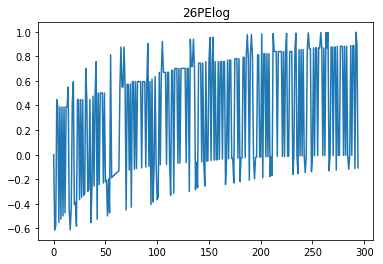

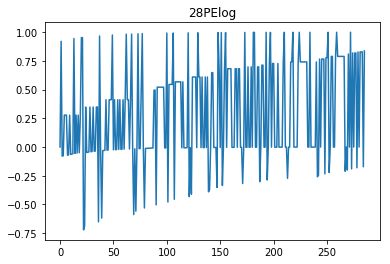

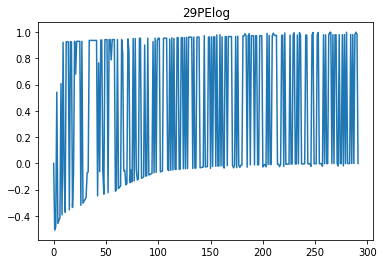

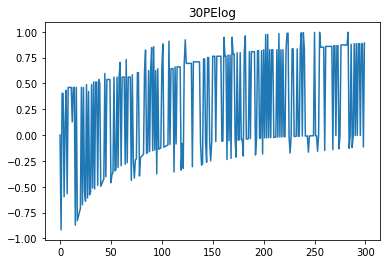

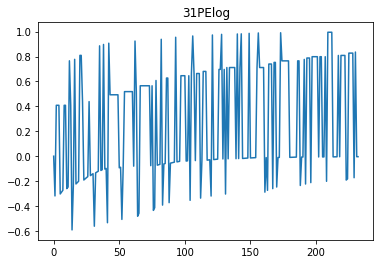

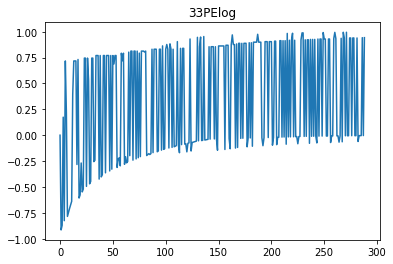

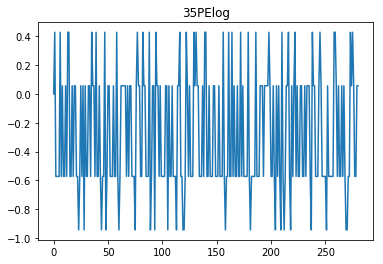

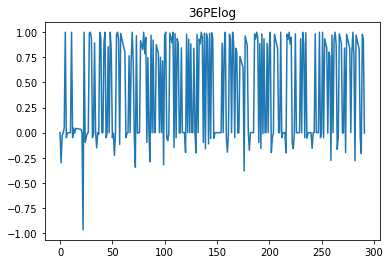

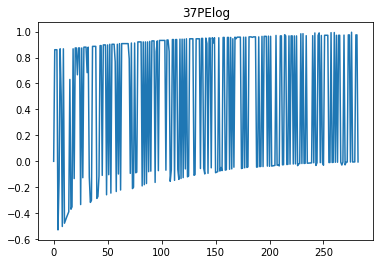

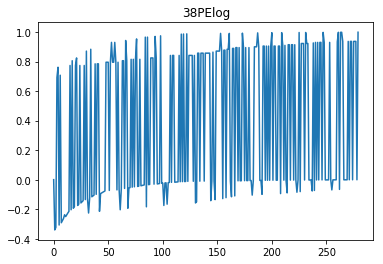

In [142]:
count=1
for rat in rats:
    plt.figure(count)
    count+=1
    plt.plot(rats[rat][0].PElog)
    plt.title(str(rat)+'PElog')
    plt.savefig(plt_path+str(rat)+'PElog.png', bbox_inches='tight')

# Part two: import EEG

In [7]:
test_rats=rat_2_anal[:2]
test_rats

[26, 28]

## Generating Label Plots

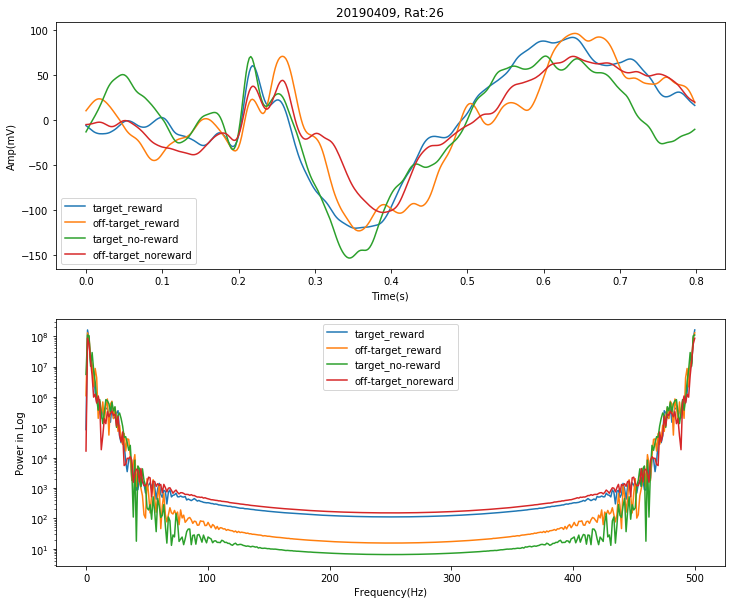

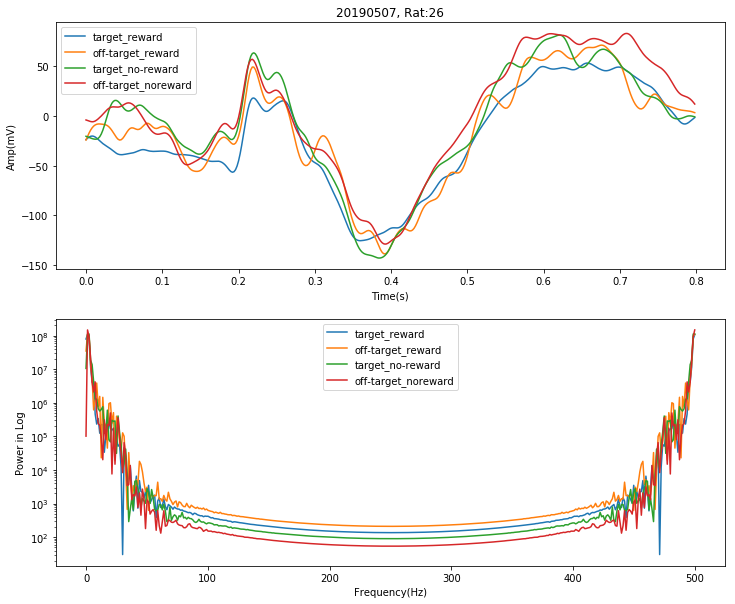

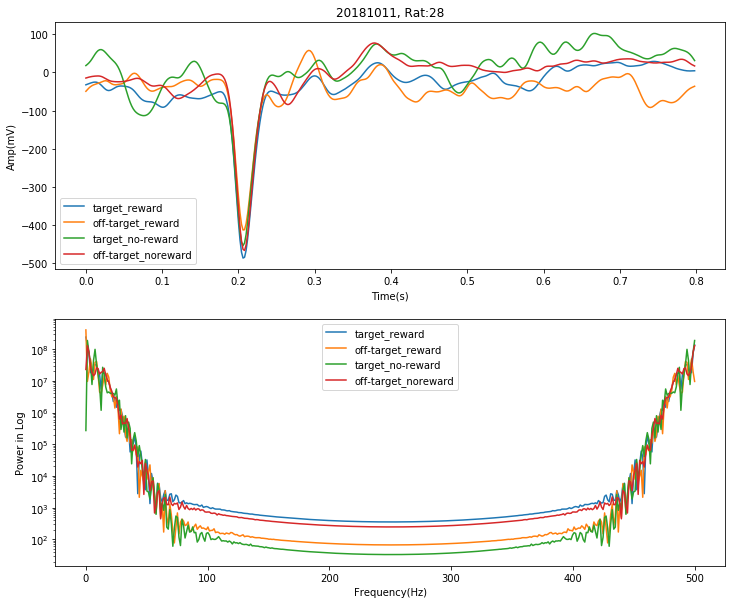

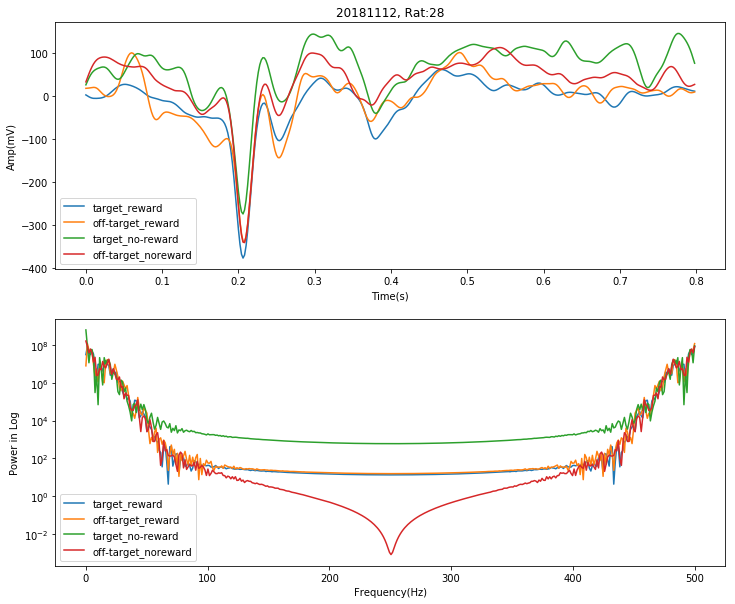

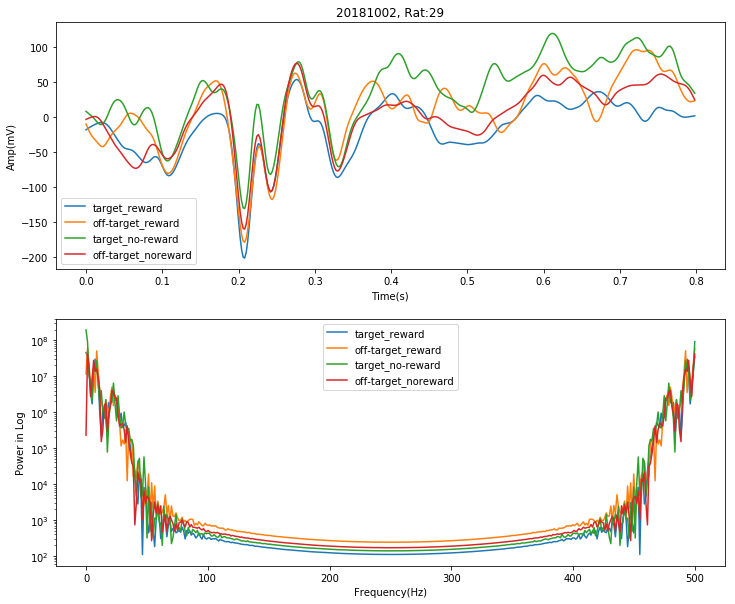

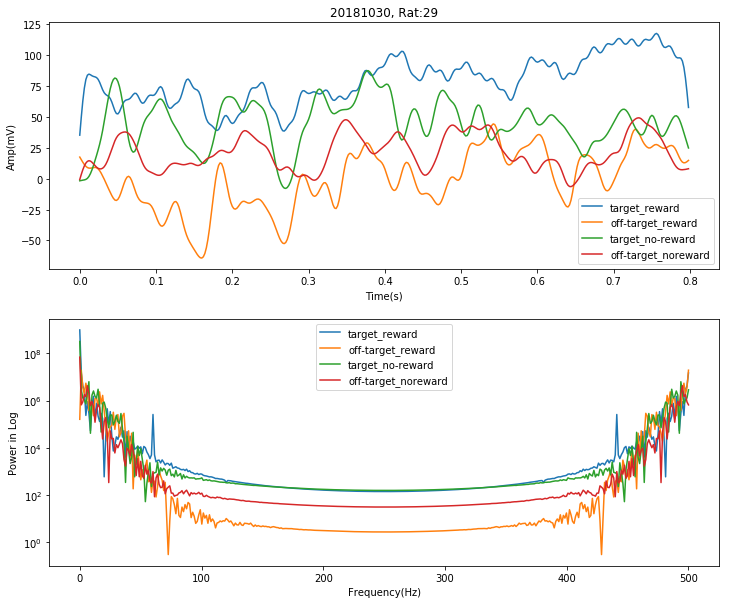

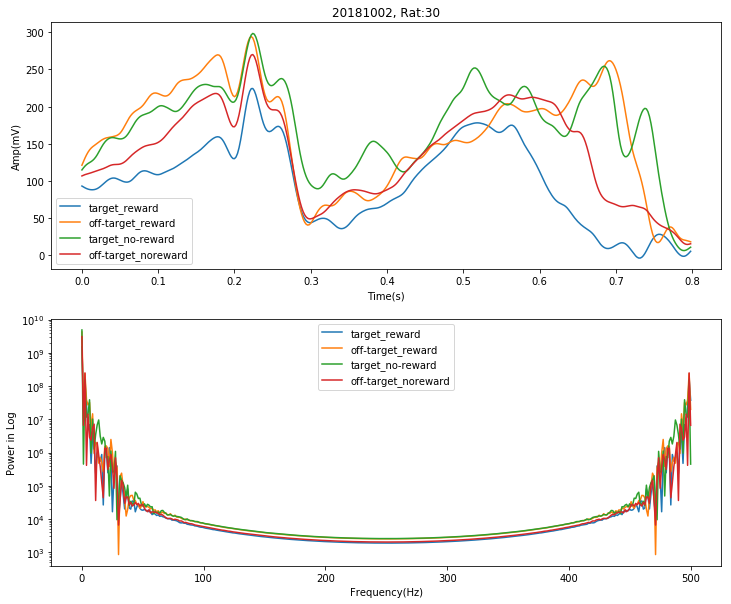

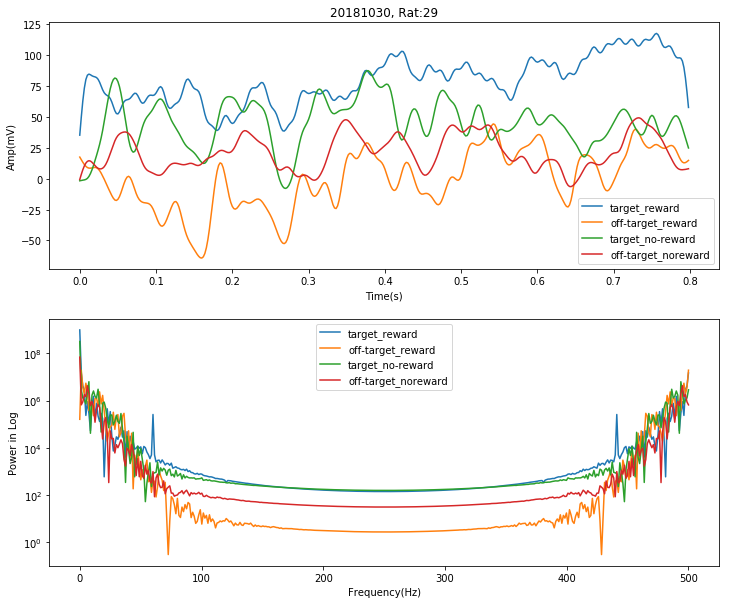

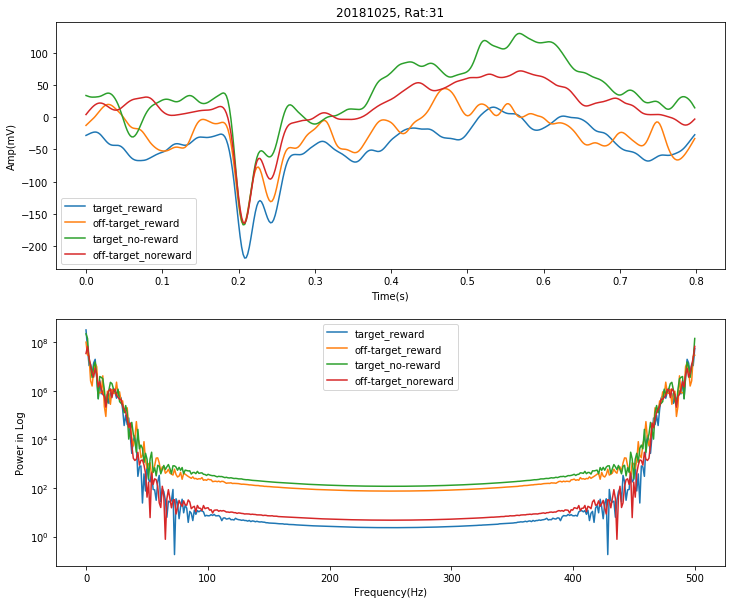

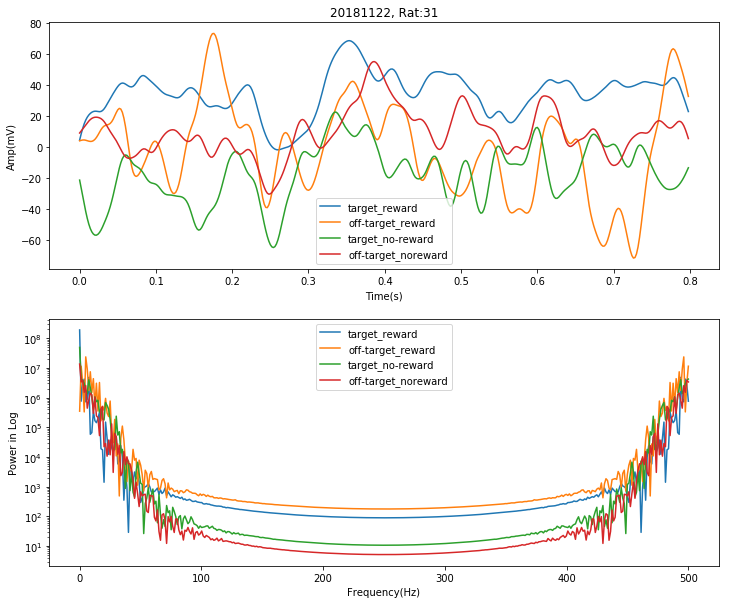

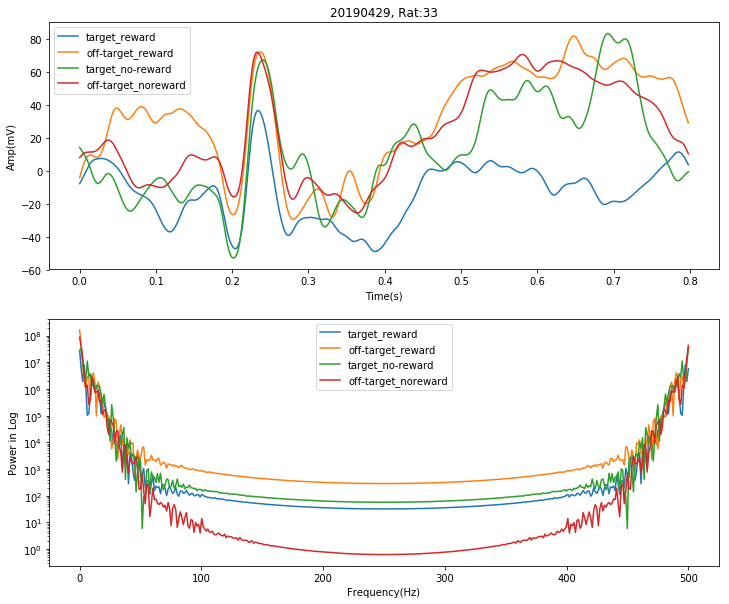

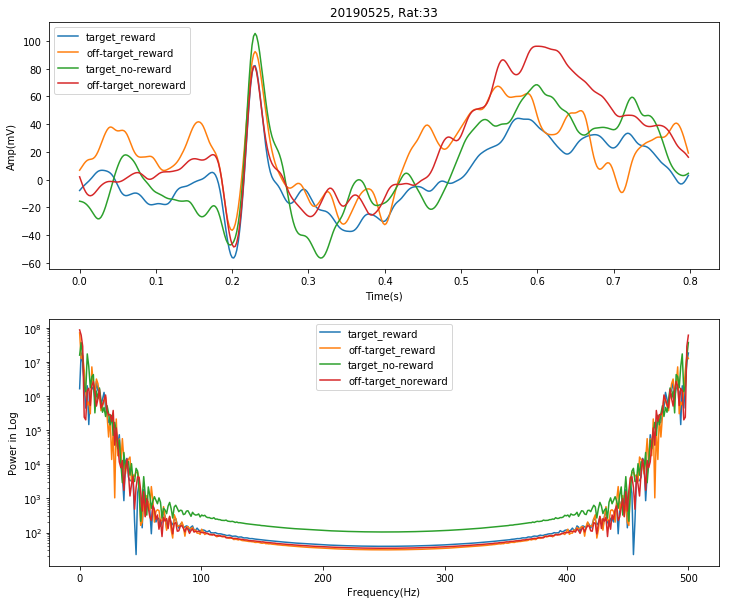

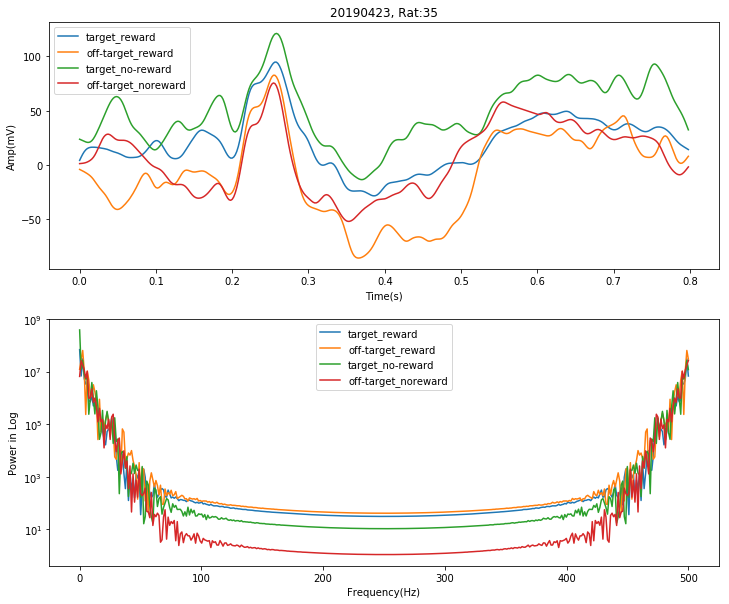

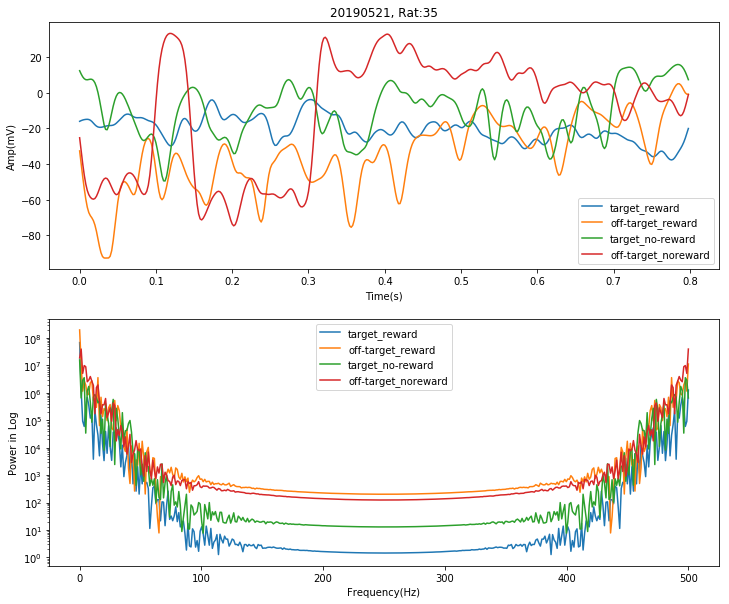

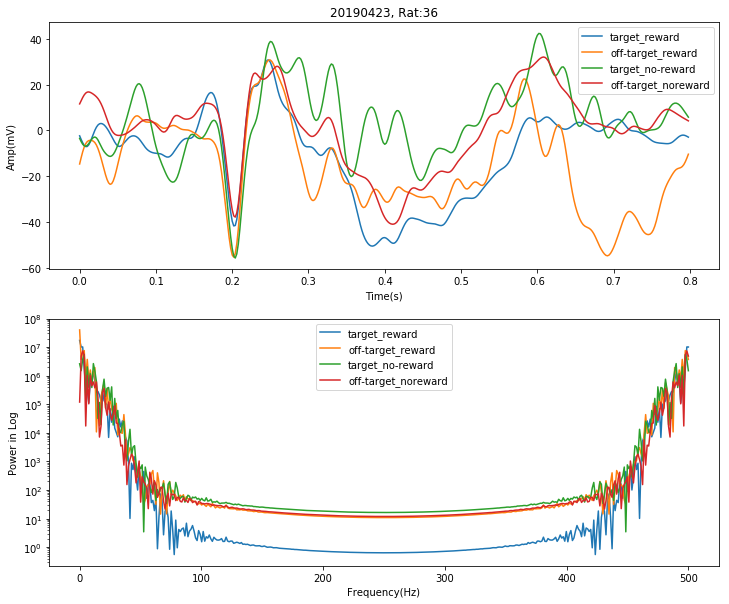

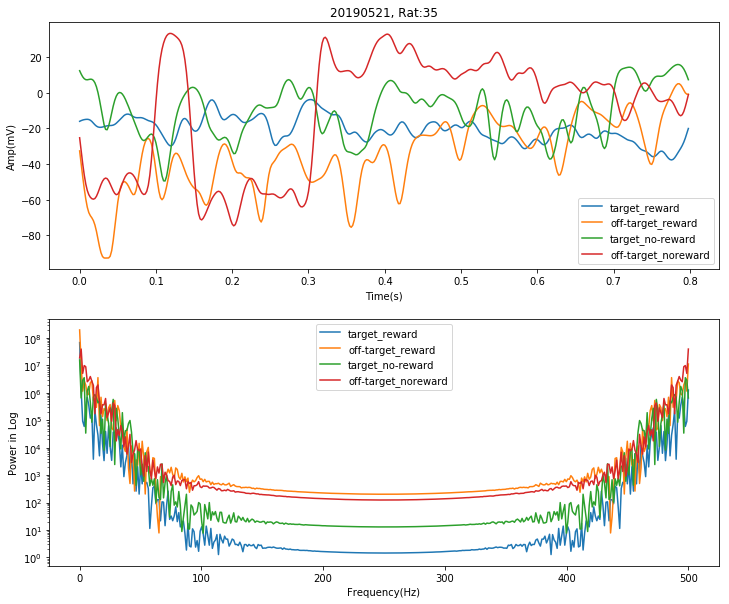

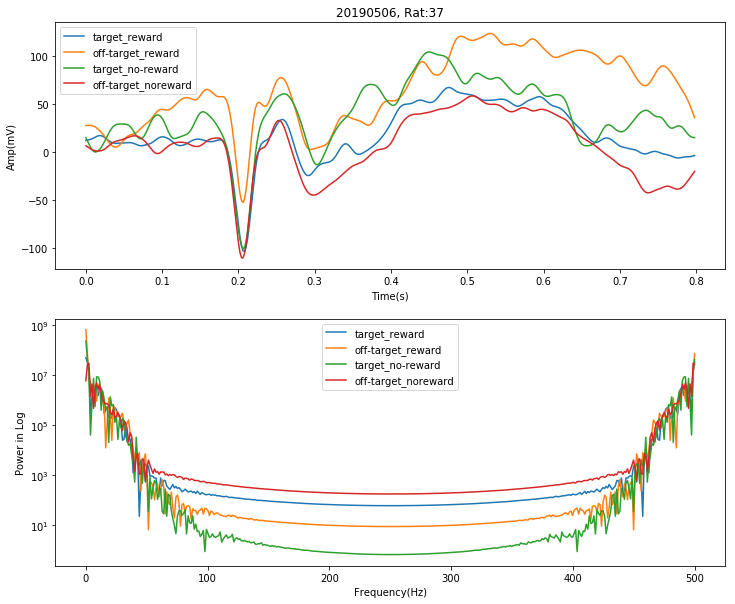

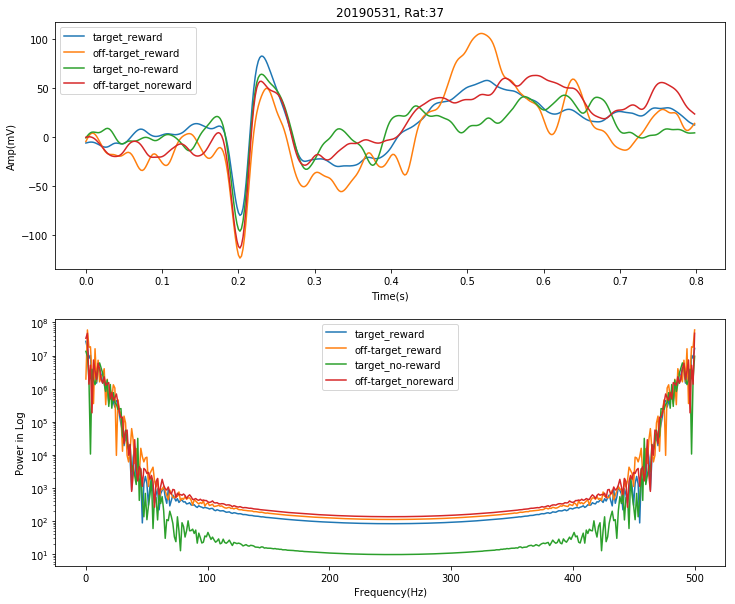

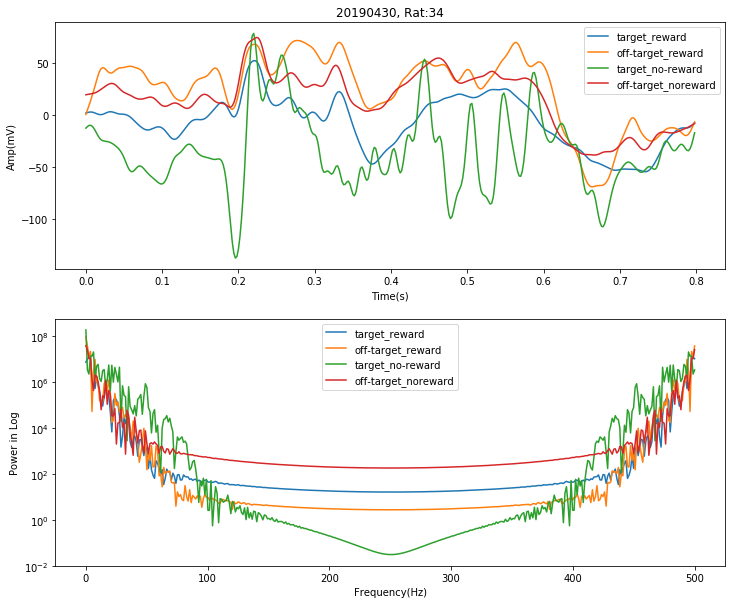

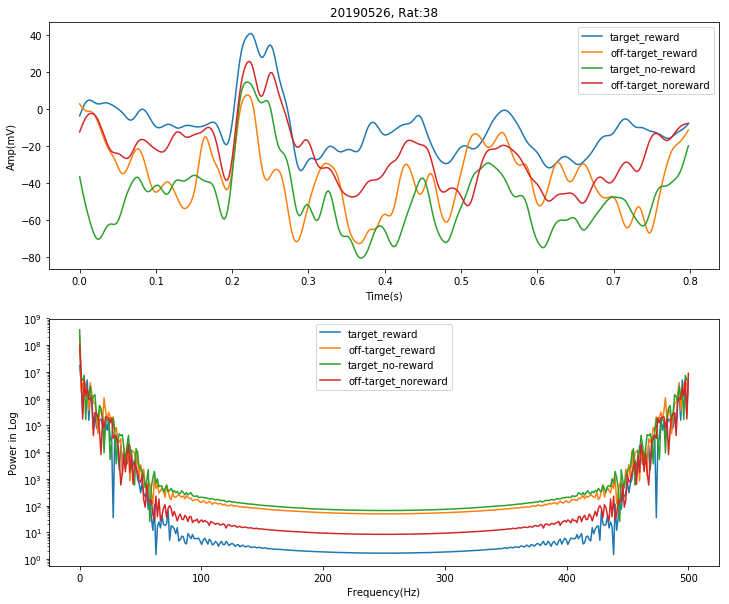

In [25]:
indx=np.array([])
count=1
for rat in rat_2_anal:
    val_chan,chan_name,dates,rat_nums,reward_tone=IE.get_excel_info(rat)
    for day in range(days):
        plt.figure(count,figsize=(12,10))
        count+=1
        plt.subplot(2,1,1)
        rat_df=IE.get_ephys(dates[day],rat_nums[day])
        tar_r=IE.eeg_by_label(rat_df,1,1) # default channel 19
        off_r=IE.eeg_by_label(rat_df,2,1)
        tar_n=IE.eeg_by_label(rat_df,1,0)
        off_n=IE.eeg_by_label(rat_df,2,0)
        erp1=IE.plot_average(tar_r,fil=True) # specify filter range here
        erp2=IE.plot_average(off_r,fil=True)
        erp3=IE.plot_average(tar_n,fil=True)
        erp4=IE.plot_average(off_n,fil=True)
        plt.title(str(dates[day])+', Rat:'+str(rat_nums[day]))
        plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
        plt.subplot(2,1,2)
        IE.spec_plot(erp1)
        IE.spec_plot(erp2)
        IE.spec_plot(erp3)
        IE.spec_plot(erp4)
        plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
        plt.savefig(ERP_plot_path+str(rat_nums[day])+str(dates[day])+'EEGplots.png', bbox_inches='tight')